### **Importar e limpar Dataset**

In [1]:
import pandas as pd

In [25]:
# Importar dataset
df = pd.read_csv('raw_data/validated.tsv', sep='\t')

/tmp/ipykernel_2451/975782715.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('raw_data/validated.tsv', sep='\t')


In [22]:
#Selecionar colunas para uso
df_clean = df[['sentence_id','path','sentence', 'gender','variant', 'age', 'accents']]

In [24]:
#Selecionar apenas os aúdios em Português (Brasil)
df_usable = df_clean[df_clean['variant'] == 'Portuguese (Brasil)'].dropna().reset_index().drop(columns=['index'])

In [32]:
#Adicionar uma coluna com a contagem de caracteres do áudio para selecionar apenas os 50 maiores
df_usable['count_caracteres'] = df_usable['sentence'].str.len()

In [26]:
#Disponibilzar a sentença inteira do áudio para leitura
pd.set_option('display.max_colwidth', None)
a = df_usable[df_usable['path'] == 'common_voice_pt_32804409.mp3']
a['sentence']

7359    Meu nome está nas manchetes”, disse o velho.\t\t4\t0\tsixties\tmale_masculine\tPaulistano.\tPortuguese (Brasil)\tpt\t\nf4d2516d878b2fc3b099914b5c7089abec30827a452b7200bc282a7f299f83c780e38371380cef31faf101439a5965b0edd9c0231c4964fda221c96c0bc462fb\tcommon_voice_pt_32804420.mp3\teb8a2331547b204c4a5cfac5d1ce4b0bc505bf839558cee5725e5d80c33356ed\tLagoa da Confusão\t\t4\t0\tsixties\tmale_masculine\tPaulistano.\tPortuguese (Brasil)\tpt\t\nf4d2516d878b2fc3b099914b5c7089abec30827a452b7200bc282a7f299f83c780e38371380cef31faf101439a5965b0edd9c0231c4964fda221c96c0bc462fb\tcommon_voice_pt_32804422.mp3\te4186a28d767a46d5b2d35e5906cfe395c908f234495912f67dcc44655bf546e\tEu andei por mais de duas horas depois de ouvir o guia de áudio.\t\t6\t0\tsixties\tmale_masculine\tPaulistano.\tPortuguese (Brasil)\tpt\t\nf4d2516d878b2fc3b099914b5c7089abec30827a452b7200bc282a7f299f83c780e38371380cef31faf101439a5965b0edd9c0231c4964fda221c96c0bc462fb\tcommon_voice_pt_32804423.mp3\td68e5ccbbf0f57d13a1e94604dfce4

In [33]:
#Selecionar 50 aúdios para posterior transcrição e análise
pd.reset_option('display.max_colwidth', None)
lista = ['path', 'sentence', 'count_caracteres']
df_usable[lista].sort_values(by='count_caracteres', ascending=False).head(5)

,path,sentence,count_caracteres
7359,common_voice_pt_32804409.mp3,"Meu nome está nas manchetes”, disse o velho.\t...",328780
4395,common_voice_pt_34645484.mp3,"É um código!”, disse a garota, bem satisfeita\...",26082
6171,common_voice_pt_35904061.mp3,"Meu nome está nas manchetes”, disse o velho.\t...",14463
690,common_voice_pt_37591374.mp3,"actínio, tório, protactínio, urânio, netúnio, ...",134
19674,common_voice_pt_36872616.mp3,"xaroposo, litosfera, crosta terrestre, lúmen, ...",128


In [8]:
#Baixar o arquivo em csv
#df_usable.to_csv('raw_data/dataset_clean.csv', sep=';', index=True)

### **Modelo google speech para transcrição**

In [47]:
#Instalação de bibliotecas usadas para as análises
!pip install pydub
!pip install SpeechRecognition
!pip install librosa
!pip install jiwer
!pip install unidecode

^C


In [34]:
import librosa
import librosa.display
import IPython.display as ipd

In [35]:
#Áudios do dataset
y, sr = librosa.load('/home/akira/code/acbarrosramos/voice_to_action/cv-corpus-17.0-2024-03-15-pt/cv-corpus-17.0-2024-03-15/pt/sample_data/common_voice_pt_37591374.mp3')
ipd.Audio(y, rate=sr)

In [43]:
#Função para transcrição dos áudios do dataset

from pydub import AudioSegment
import speech_recognition as sr
import io
import os

def speech_to_text(audio_file):

    recognizer = sr.Recognizer()

    file_extension = os.path.splitext(audio_file)[1][1:]

    audio_data = AudioSegment.from_file(audio_file, format=file_extension)

    # Converter para WAV e criar um buffer de bytes --preprocessing
    wav_buffer = io.BytesIO()
    audio_data.export(wav_buffer, format="wav")  # Converta para WAV
    wav_buffer.seek(0)

    # Usar BytesIO como entrada para o Recognizer
    with sr.AudioFile(wav_buffer) as source:
        audio_data = recognizer.record(source)

    try:
        text = recognizer.recognize_google(audio_data, language='pt-BR')
        return text

    except sr.UnknownValueError:
        return "Não foi possível entender o áudio"
    except sr.RequestError as e:
        return "Erro ao solicitar reconhecimento de fala; {0}".format(e)


audio_file = "/home/akira/code/acbarrosramos/voice_to_action/cv-corpus-17.0-2024-03-15-pt/cv-corpus-17.0-2024-03-15/pt/sample_data/common_voice_pt_24662841.mp3"
texto_transcrito = speech_to_text(audio_file)
texto_transcrito

'mãe'

In [81]:
#Função para transcrever cada um dos 50 arquivos selecionados do dataset

def transcrever_arquivos_na_pasta(pasta):
    transcricoes = []

    for nome_arquivo in os.listdir(pasta):
        caminho_completo = os.path.join(pasta, nome_arquivo)
        if os.path.isfile(caminho_completo) and nome_arquivo.endswith('.mp3'):
            #print(f"Processando arquivo: {nome_arquivo}")
            texto_transcrito = speech_to_text(caminho_completo)
            transcricoes.append({'path': nome_arquivo, 'texto_transcrito_modelo': texto_transcrito})

    df_transcricoes = pd.DataFrame(transcricoes)
    return df_transcricoes

### **Merge: Dataframe + transcrições**

In [82]:
#Dataframe com as transcrições
pasta = '/home/akira/code/acbarrosramos/voice_to_action/cv-corpus-17.0-2024-03-15-pt/cv-corpus-17.0-2024-03-15/pt/sample_data/'

df_transcricoes = transcrever_arquivos_na_pasta(pasta)
df_transcricoes.head(5)

,path,texto_transcrito_modelo
0,common_voice_pt_36872065.mp3,cabeçote Coligação pantográfico craniano mutuá...
1,common_voice_pt_36862628.mp3,logaritmo decimal material Longitude meridiano...
2,common_voice_pt_32172665.mp3,meninas e adolescentes que apresentam necessid...
3,common_voice_pt_30580984.mp3,trabalhos posteriores foram realizados onde fo...
4,common_voice_pt_36455648.mp3,trabalhos posteriores foram realizados onde fo...


In [54]:
#Dataframe para analisar texto transcrito
lista_variaveis = ['path', 'sentence', 'count_caracteres']
df_concat = df_usable[lista_variaveis].merge(df_transcricoes, how='inner', on='path')
df_concat.tail(5)

,path,sentence,count_caracteres,texto_transcrito_modelo
45,common_voice_pt_31750547.mp3,"Compartilhá-los será impossível, pelo menos us...",99,compartilhar alos será impossível pelo menos u...
46,common_voice_pt_32085492.mp3,"Todos os dias, empresas e profissionais presta...",98,todos os dias empresas e profissionais prestam...
47,common_voice_pt_32172665.mp3,meninas e adolescentes que apresentam necessid...,108,meninas e adolescentes que apresentam necessid...
48,common_voice_pt_32258477.mp3,Luz,3,luz
49,common_voice_pt_32348921.mp3,Selecione produtos para preparar calorias e pr...,110,selecione produtos para preparar calorias e pr...


### **Validação antes da normalização do modelo com base em WER e CER**

In [56]:
#Função para validar o modelo de transcrição com base nas palavras e nos caracteres
#Word Error Rate (WER): taxa de acerto das palavras transcritas (0 a 1, quanto mais perto de 1 mais errada a transcrição)
#Character Error Rate (CER): taxa de acerto dos caracteres transcritos (0 a 1, quanto mais perto de 1 mais errada a transcrição)

from jiwer import wer, cer

def validar_transcricoes(df_validado):
    df_validado['WER'] = df_validado.apply(lambda row: wer(row['sentence'], row['texto_transcrito_modelo']), axis=1)
    df_validado['CER'] = df_validado.apply(lambda row: cer(row['sentence'], row['texto_transcrito_modelo']), axis=1)
    return df_validado

df_validado = validar_transcricoes(df_concat)
df_validado.head(5)

,path,sentence,count_caracteres,texto_transcrito_modelo,WER,CER
0,common_voice_pt_37591374.mp3,"actínio, tório, protactínio, urânio, netúnio, ...",134,actine otorio protactínio urânio Netuno ameríc...,1.000000,0.462687
1,common_voice_pt_37526011.mp3,"disfunção sexual, erétil, ejaculação precoce, ...",115,disfunção sexual erétil ejaculação precoce vag...,0.583333,0.060870
2,common_voice_pt_37274519.mp3,"eletroafinidade, eletronegatividade, eletropos...",121,eletroafinidade eletronegatividade eletroposit...,1.222222,0.099174
3,common_voice_pt_32308715.mp3,Cipó,4,Cipó,0.000000,0.000000
4,common_voice_pt_32341511.mp3,Iepê,4,Iepê,0.000000,0.000000


In [58]:
taxa_erro_média = df_validado['CER'][df_validado['CER']<1].mean()
print(f'A taxa de erros de caracteres média antes da normalização foi de {round(taxa_erro_média*100,2)}%')

A taxa de erros de caracteres média antes da normalização foi de 12.57%


### **Validação após normalizar a transcrição do modelo com base em WER e CER (retirada de acentos)**

In [60]:
#Função para remover acentos das palavras
from unidecode import unidecode

def remover_acentos(palavra):
    return unidecode(palavra)

In [64]:
df_validado['dataset_normalizado'] = df_validado['sentence'].apply(remover_acentos)
df_validado['transcricao_normalizada'] = df_validado['texto_transcrito_modelo'].apply(remover_acentos)
df_validado.head(10)

,path,sentence,count_caracteres,texto_transcrito_modelo,WER,CER,dataset_normalizado,transcricao_normalizada
0,common_voice_pt_37591374.mp3,"actínio, tório, protactínio, urânio, netúnio, ...",134,actine otorio protactínio urânio Netuno ameríc...,1.000000,0.462687,"actinio, torio, protactinio, uranio, netunio, ...",actine otorio protactinio uranio Netuno americ...
1,common_voice_pt_37526011.mp3,"disfunção sexual, erétil, ejaculação precoce, ...",115,disfunção sexual erétil ejaculação precoce vag...,0.583333,0.060870,"disfuncao sexual, eretil, ejaculacao precoce, ...",disfuncao sexual eretil ejaculacao precoce vag...
2,common_voice_pt_37274519.mp3,"eletroafinidade, eletronegatividade, eletropos...",121,eletroafinidade eletronegatividade eletroposit...,1.222222,0.099174,"eletroafinidade, eletronegatividade, eletropos...",eletroafinidade eletronegatividade eletroposit...
3,common_voice_pt_32308715.mp3,Cipó,4,Cipó,0.000000,0.000000,Cipo,Cipo
4,common_voice_pt_32341511.mp3,Iepê,4,Iepê,0.000000,0.000000,Iepe,Iepe
5,common_voice_pt_35160648.mp3,mês,3,mês,0.000000,0.000000,mes,mes
6,common_voice_pt_35911777.mp3,Eu?,3,Não foi possível entender o áudio,6.000000,10.666667,Eu?,Nao foi possivel entender o audio
7,common_voice_pt_32886098.mp3,Mas barreiras também são encontradas em nossos...,99,as barreiras também são encontradas em nossos ...,0.333333,0.040404,Mas barreiras tambem sao encontradas em nossos...,as barreiras tambem sao encontradas em nossos ...
8,common_voice_pt_36455648.mp3,Trabalhos posteriores foram realizados onde fo...,108,trabalhos posteriores foram realizados onde fo...,0.214286,0.046296,Trabalhos posteriores foram realizados onde fo...,trabalhos posteriores foram realizados onde fo...
9,common_voice_pt_30580984.mp3,Trabalhos posteriores foram realizados onde fo...,108,trabalhos posteriores foram realizados onde fo...,0.142857,0.018519,Trabalhos posteriores foram realizados onde fo...,trabalhos posteriores foram realizados onde fo...


In [65]:
def validar_transcricoes_normalizadas(df_validado):
    df_validado['WER_normalizado'] = df_validado.apply(lambda row: wer(row['dataset_normalizado'], row['transcricao_normalizada']), axis=1)
    df_validado['CER_normalizado'] = df_validado.apply(lambda row: cer(row['dataset_normalizado'], row['transcricao_normalizada']), axis=1)
    return df_validado

df_validado = validar_transcricoes_normalizadas(df_concat)
df_validado.head(5)

,path,sentence,count_caracteres,texto_transcrito_modelo,WER,CER,dataset_normalizado,transcricao_normalizada,WER_normalizado,CER_normalizado
0,common_voice_pt_37591374.mp3,"actínio, tório, protactínio, urânio, netúnio, ...",134,actine otorio protactínio urânio Netuno ameríc...,1.000000,0.462687,"actinio, torio, protactinio, uranio, netunio, ...",actine otorio protactinio uranio Netuno americ...,1.000000,0.447761
1,common_voice_pt_37526011.mp3,"disfunção sexual, erétil, ejaculação precoce, ...",115,disfunção sexual erétil ejaculação precoce vag...,0.583333,0.060870,"disfuncao sexual, eretil, ejaculacao precoce, ...",disfuncao sexual eretil ejaculacao precoce vag...,0.583333,0.060870
2,common_voice_pt_37274519.mp3,"eletroafinidade, eletronegatividade, eletropos...",121,eletroafinidade eletronegatividade eletroposit...,1.222222,0.099174,"eletroafinidade, eletronegatividade, eletropos...",eletroafinidade eletronegatividade eletroposit...,1.222222,0.099174
3,common_voice_pt_32308715.mp3,Cipó,4,Cipó,0.000000,0.000000,Cipo,Cipo,0.000000,0.000000
4,common_voice_pt_32341511.mp3,Iepê,4,Iepê,0.000000,0.000000,Iepe,Iepe,0.000000,0.000000


Text(0.5, 0, 'Resultado da validação: Mais perto de 0, boa transcrição')

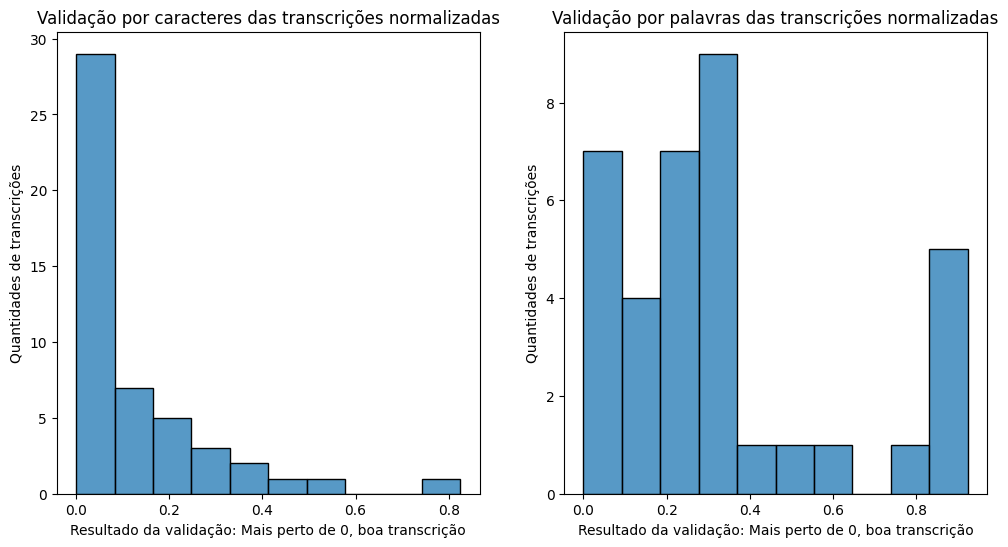

In [78]:
#Gráfico para visualizar as validações por caracteres das transcrições normalizadas
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Primeiro gráfico: Validação por caracteres
sns.histplot(df_validado['CER_normalizado'][df_validado['CER_normalizado']<1], bins=10, ax=axs[0])
axs[0].set_title('Validação por caracteres das transcrições normalizadas')
axs[0].set_ylabel('Quantidades de transcrições')
axs[0].set_xlabel('Resultado da validação: Mais perto de 0, boa transcrição')

#Segundo gráfico
sns.histplot(df_validado['WER_normalizado'][df_validado['WER_normalizado']<1], bins=10, ax=axs[1])
axs[1].set_title('Validação por palavras das transcrições normalizadas')
axs[1].set_ylabel('Quantidades de transcrições')
axs[1].set_xlabel('Resultado da validação: Mais perto de 0, boa transcrição')